# <h1>System Code Review </h1>

This notebook pertains to the review of the code for the BRIDGE_word_proximity project. The project's main objective is to track a certain behaviour in an <strong>embedding</strong> space. The embedding space is generated by the execution of a transformer-based framework. The embeddings relate to the prediction of specific <i>individual</i> words (i.e. 'hello' , 'cherry', 'fire' etc. etc.). 

The behaviour that is to be analyzed is the proximity of these words through various pairwise distance matrices. By proximity, what is meant is <i>similarity</i>, interpreted as the proximity between the pairwise distance matrix values. Embeddings are generated at each epoch of the transformer execution, and the for each epoch a pairwise distance matrix is generated. 

The objective of the project is to track the similarity of 1 word and its n-Nearest Neighbors over the epochs. 


## <h2>Problem</h2>

It has been observed that the distance between the words increase as the epochs progress. This behaviour is not expected (since the model should be learning more and more each epoch, the distances between words should shorten). This has triggered a code review. 

## Stages of Review 

### 1. Pairwise Distance Matrix Calculation

By providing each epoch's generated embeddings, the pairwise distance matrix for each epochs is produced.
Files involved:
- product_pdist_matrices.py

### 2. n-Nearest Neighbors calculation from last epoch

The n-Nearest Neighbors are calculated, using the specific word provided by the user. They are first calculated using the last epoch's pairwise distance matrix. 
Files involved:
- main_multiple.py
- nearest_neighbors.py

### 3. Pairwise Distance Matrices Loading and n-Nearest Neighbors calculations

The other epoch's distance matrices are loaded, and the distance between the provided words from the previous section and the word chosen by the user is calculated.
Files involved:
- main_multiple.py
- distance_between_words.py

### 4. Data plotting and visualization

The information obtained from the previous steps is plotted on a line graph. The x-axis represents the epoch number, while the y-axis represents the distance of each word from the baseline word. 
Files involved:
- main_multiple.py


# Import of all project-related code 

In [1]:
#pairwise_distance_matrix.py
import pandas as pd
from scipy.spatial import distance_matrix
def pairwise_distance_matrix(fraction: float = 1.0):
    """
    Generates a pairwise distance matrix for word embeddings.
    
    Args:
    fraction (float): Fraction of the data to sample from the dataset. Default is 1.0 (100% of the data).

    Returns:
    pd.DataFrame: A DataFrame where rows and columns are words and cell values are distances.
    """

    # Load the dataset from an Excel file located in a Data folder
    df = pd.read_excel('./Data/model_root_2024_mohammed.xlsx')
    
    # Sample a fraction of the data to reduce computation time if needed
    df_fraction = df.sample(frac=fraction)
    
    # Update the dataframe to only include the sampled data
    df = df_fraction

    # Split the 'global_encoding' column into multiple columns at each ':'
    split_columns = df['global_encoding'].str.split(':', expand=True)
    
    # Rename the newly created columns to 'dim_1', 'dim_2', ..., 'dim_n'
    split_columns.columns = [f'dim_{i+1}' for i in range(split_columns.shape[1])]
    
    # Concatenate the new dimensions back to the original dataframe
    new_df = pd.concat([df['word_raw'], split_columns], axis=1)

    # Generate a list of new column names for embeddings to numeric conversion
    embedding_columns = [f'dim_{i+1}' for i in range(128)]  # Assumes 128 dimensions for embeddings
    
    # Convert all embedding columns to numeric, coercing errors to NaN (useful for corrupt data)
    new_df[embedding_columns] = new_df[embedding_columns].apply(pd.to_numeric, errors='coerce')
    
    # Extract the numerical embeddings into a NumPy array for distance computation
    embeddings = new_df[embedding_columns].values
    
    # Calculate the pairwise distance matrix using the embeddings
    dist_matrix = distance_matrix(embeddings, embeddings)
    
    # Create a DataFrame from the distance matrix, labeling rows and columns with the corresponding words
    dist_df = pd.DataFrame(dist_matrix, index=new_df['word_raw'], columns=new_df['word_raw'])

    # Return the DataFrame containing the pairwise distances
    return dist_df


In [2]:
#distance_between_words.py
def distance_between_words(word1, word2, dist_df):
    """
    Finds the distance between two given words in a provided distance matrix.

    Args:
    word1 (str): The first word.
    word2 (str): The second word to find the distance to.
    dist_df (pd.DataFrame): A DataFrame where each row and column represent words,
                            and the values are the distances between them.

    Returns:
    float or str: The distance between the two words if both are found in the DataFrame,
                  otherwise returns an error message if one or both words are missing.
    """
    # Check if both words are in the DataFrame
    if word1 not in dist_df.columns or word2 not in dist_df.columns:
        return "One or both words not found in the distance matrix."

    # Retrieve the distance between word1 and word2
    distance = dist_df.loc[word1, word2]

    # Return the distance
    return distance

In [3]:
#nearest_neighbors.py
def nearest_neighbors(word, n, dist_df):
    """
    Finds the n nearest neighbors of a given word in a provided distance matrix.
    
    Args:
    word (str): The word to find the neighbors for.
    n (int): Number of neighbors to retrieve.
    dist_df (pd.DataFrame): A DataFrame where each row and column represent words,
                            and the values are the distances between them.

    Returns:
    list: A list of dictionaries where each dictionary contains a 'word' and its 'distance'
          from the input word. If the word is not found, returns a string message.
    """

    # Retrieve the row corresponding to 'word', which contains distances to all other words
    distances = dist_df.loc[word]

    # Sort the distances while excluding the first element (distance to itself, which is zero)
    nearest = distances.sort_values().iloc[1:n+1]

    # Create a list of dictionaries for each neighboring word and its distance
    neighbors = [{'word': idx, 'distance': dist} for idx, dist in nearest.items()]

    # Check if 'the' is in the nearest neighbors but not included in the final list (due to an edge case or a bug)
    if 'the' in nearest and 'the' not in [neighbor['word'] for neighbor in neighbors]:
        # Extract the distance to 'the' from the DataFrame
        the_distance = distances['the']
        
        # Append the missing 'the' to the list of neighbors
        neighbors.append({'word': 'the', 'distance': the_distance})
    
    # Return the list of nearest neighbors
    return neighbors


In [4]:
#main_multiple.py
import os 
import sys
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import argparse


def nearest_neighbors(word, n, dist_df):
    """
    Finds the n nearest neighbors of a given word in a provided distance matrix.
    
    Args:
    word (str): The word to find the neighbors for.
    n (int): Number of neighbors to retrieve.
    dist_df (pd.DataFrame): A DataFrame where each row and column represent words,
                            and the values are the distances between them.

    Returns:
    list: A list of dictionaries where each dictionary contains a 'word' and its 'distance'
          from the input word. If the word is not found, returns a string message.
    """

    # Retrieve the row corresponding to 'word', which contains distances to all other words
    distances = dist_df.loc[word]

    # Sort the distances while excluding the first element (distance to itself, which is zero)
    nearest = distances.sort_values().iloc[1:n+1]

    # Create a list of dictionaries for each neighboring word and its distance
    neighbors = [{'word_raw': idx, 'distance': dist} for idx, dist in nearest.items()]

    # Check if 'the' is in the nearest neighbors but not included in the final list (due to an edge case or a bug)
    if 'the' in nearest and 'the' not in [neighbor['word_raw'] for neighbor in neighbors]:
        # Extract the distance to 'the' from the DataFrame
        the_distance = distances['the']
        
        # Append the missing 'the' to the list of neighbors
        neighbors.append({'word_raw': 'the', 'distance': the_distance})
    
    # Return the list of nearest neighbors
    return neighbors





def plot_word_distances(data, specific_word, n):
    """
    Plots the distances over epochs for different words, given a DataFrame where
    each 'word' column contains a dictionary with 'word_raw' and other details.

    Args:
    data (list of dicts): The data containing epochs, words, and distances.
    """
    # Convert list of dictionaries to a DataFrame
    df = pd.DataFrame(data)

    # Flatten the 'word' column to extract the 'word_raw' and sort by 'epoch'
    df['word'] = df['word'].apply(lambda x: x['word'])
    df.sort_values(by='epoch', inplace=True)

    # Get unique words for plotting
    unique_words = df['word'].unique()
    
    plot = plt.figure(figsize=(10, 6))

    for word in unique_words:
        # Filter data for each word and plot
        word_data = df[df['word'] == word]
        plt.plot(word_data['epoch'], word_data['distance'], label=word)  # Plot each word's time series

    plt.xlabel('Epoch')
    plt.ylabel('Distance')
    plt.title('Distance of Words Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()



def load_csv_dataframes(directory):
    files = os.listdir(directory)
    data_list = []
    for file in files:
        if file.endswith('_pdist.csv'):
            epoch = int(file.split('_')[0])
            dataframe = pd.read_csv(os.path.join(directory, file))
            if 'word_raw' in dataframe.columns:
                dataframe.set_index('word_raw', inplace=True)
            data_list.append({'epoch': epoch, 'dataframe': dataframe})
    return data_list

def find_latest_epoch_csv(directory):
    files = os.listdir(directory)

    
    max_epoch = -1
    latest_file = None
    
    for file in files:
        if file.endswith('_pdist.csv'):
            epoch = int(file.split('_')[0])
            if epoch > max_epoch:
                max_epoch = epoch
                latest_file = file
    
    return latest_file


word_list_g = []


def load_csv_dataframes(directory):
    files = os.listdir(directory)
    data_list = []
    for file in files:
        if file.endswith('_pdist.csv'):
            epoch = int(file.split('_')[0])
            dataframe = pd.read_csv(os.path.join(directory, file))
            if 'word_raw' in dataframe.columns:
                dataframe.set_index('word_raw', inplace=True)
            data_list.append({'epoch': epoch, 'dataframe': dataframe})
    return data_list

def find_latest_epoch_csv(directory):
    files = os.listdir(directory)

    
    max_epoch = -1
    latest_file = None
    
    for file in files:
        if file.endswith('_pdist.csv'):
            epoch = int(file.split('_')[0])
            if epoch > max_epoch:
                max_epoch = epoch
                latest_file = file
    
    return latest_file

def main():
    parser = argparse.ArgumentParser(description='Process some integers.')
    parser.add_argument('specific_word', type=str, help='Specific word to analyze')
    parser.add_argument('n', type=int, help='Number of nearest neighbors')
    args = parser.parse_args()
    directory = 'distance_matrices/'
    max_epoch = find_latest_epoch_csv(directory)
    dataframess = pd.read_csv(directory + '/' + max_epoch)
    if 'word_raw' in dataframess.columns:
            dataframess.set_index('word_raw', inplace=True)

    words = nearest_neighbors(args.specific_word, args.n, dataframess)
    dataframes = load_csv_dataframes(directory)
    word_list = []
    for word in words:
        for dataframe in dataframes:
            if 'word_raw' in dataframe['dataframe'].columns:
                dataframe['dataframe'].set_index('word_raw', inplace=True)

            distance_dict = {
                "epoch": dataframe['epoch'],
                "word": word,
                "distance": distance_between_words('hello', word['word_raw'], dataframe['dataframe']),
            }
            word_list.append(distance_dict)
    print(word_list)
    plot_word_distances(word_list, args.specific_word, args.n)


### Thoughts / Theories 

The are 2 types of revisions to be made:

1. Syntax Revision -> Reviewing the code, making sure that every lne and every instructions performs exactly what you would like for it to perform. 
2. Logic Revision -> Besides the correct syntax review, make sure that the logic behind certain operations can be explained and defended.

Syntax Revision will be done through the entire code.
Logic Revision will be performed upon two main <i>Points of Contact</i>. By points of contact (POC, from now on), I intend to describe CRUCIAL operations in the code, which define the output more than others. They are the following:

- The pairwise distance matrix calculation --> The basis of the analysis; the processed code through which many simple operations are performed in order to arrive to a conclusion.
- The graphical plotting --> Through which we can visualize the direct outputs of all operations

### Review of pairwise_distance_matrix.py

### Possible problem causes

From the pairwise distance matrix, one grabs the necessary information, for each epoch, with which the similarity/distance between the words is analyzed.
It is the first step in the BRIDGE_word_proximity project. If the method with which the pairwise distance matrices is incorrect, flawed, or fundamentally misunderstood, then the entire project will surely follow. 

The first observation I would like to make is whether the n <i>closest</i> words are the same for both the first and last epoch. 
The reason for this is for the detection of <b>semantic shifts</b>. In other words, if the set of closest words changes significantly between first and last epoch, it may indicate that there has been a change, over time, in the context of which words appear, introduction of new terminologies over time, etc.. etc..
It could inform us on how the <i>idea</i>, <i>thought</i> or more trivially how the <i>concept</i> associated with a specific word evolves throughout the duration of the model training. 
In addition, it could demonstrate underlying trends present during the training.

The second observation I would like to make is how different <i>cosine-similarity</i> pairwise distance matrices are compared to the <i>euclidean distance</i> pairwise distance matrices. Could they yield better results by operating in a higher dimensional space? By "better results", I intend to describe a timeline where the similarity of words begins "low", ending "high", i.e. words are closer to each other in the end rather than the beginning. 

<b> From ChatGPT </b> <br>
<i>
This observation is crucial as it may reveal that one metric is more suited than the other for detecting gradual semantic convergence or divergence among words throughout the epochs. If, for instance, the beginning of the timeline shows low similarity scores that gradually increase, it could suggest a stabilization or standardization in the usage of certain terms. Conversely, if the similarity decreases, it could indicate a diversification in word meanings or associations. This analysis will help in determining the most appropriate metric for tracking semantic changes over time, thus enhancing the overall reliability and interpretability of the study.</i>

#### Comparing 5 most similar words in THE FIRST EPOCH to the 5 most similar words in THE LAST EPOCH

In [5]:
words_to_test = ['hello', 'sorry', 'june', 'teeth', 'tooth']

directory = '/Users/giuliomartini/Desktop/FSU/BRIDGE/BRIDGE_word_proximity/distance_matrices/'
max_epoch = find_latest_epoch_csv(directory)
dataframe_from_max_epoch = pd.read_csv(directory + '/' + max_epoch)
if 'word_raw' in dataframe_from_max_epoch.columns:
        dataframe_from_max_epoch.set_index('word_raw', inplace=True)

first_pairwise_distance_matrix = pd.read_csv(directory + '0_pdist.csv')
first_pairwise_distance_matrix.set_index('word_raw', inplace=True)

In [6]:
word_stats = []

for word in words_to_test:
    first_epoch_nearest_neighbors = nearest_neighbors(word, 5, first_pairwise_distance_matrix)
    last_epoch_nearest_neighbors = nearest_neighbors(word, 5, dataframe_from_max_epoch)

    word_stat = {
        "word" : word,
        "first_epoch_nearest_neighbor" : first_epoch_nearest_neighbors,
        "last_epoch_nearest_neighbor" : last_epoch_nearest_neighbors
    }

    word_stats.append(word_stat)

rows = []
for entry in word_stats:
    word = entry['word']
    for neighbor in entry['first_epoch_nearest_neighbor']:
        rows.append([word, 1, neighbor['word_raw'], neighbor['distance'], 'first'])
    for neighbor in entry['last_epoch_nearest_neighbor']:
        rows.append([word, 29, neighbor['word_raw'], neighbor['distance'], 'last'])

df_neighbors = pd.DataFrame(rows, columns=['word', 'epoch', 'neighbor', 'similarity', 'epoch_type'])
for index, row in df_neighbors.iterrows():
    print(f"Word: {row['word']} --> {row['epoch']} : {row['neighbor']}")

Word: hello --> 1 : shell
Word: hello --> 1 : hole
Word: hello --> 1 : cells
Word: hello --> 1 : below
Word: hello --> 1 : close
Word: hello --> 29 : close
Word: hello --> 29 : shell
Word: hello --> 29 : cells
Word: hello --> 29 : behold
Word: hello --> 29 : college
Word: sorry --> 1 : worry
Word: sorry --> 1 : story
Word: sorry --> 1 : yours
Word: sorry --> 1 : yards
Word: sorry --> 1 : drive
Word: sorry --> 29 : worry
Word: sorry --> 29 : words
Word: sorry --> 29 : crowd
Word: sorry --> 29 : proud
Word: sorry --> 29 : boris
Word: june --> 1 : jen
Word: june --> 1 : send
Word: june --> 1 : tend
Word: june --> 1 : went
Word: june --> 1 : jane
Word: june --> 29 : tune
Word: june --> 29 : snug
Word: june --> 29 : jenny
Word: june --> 29 : begun
Word: june --> 29 : enjoy
Word: teeth --> 1 : sheet
Word: teeth --> 1 : these
Word: teeth --> 1 : tenth
Word: teeth --> 1 : three
Word: teeth --> 1 : seth
Word: teeth --> 29 : seth
Word: teeth --> 29 : sheet
Word: teeth --> 29 : these
Word: teeth 

## Compute the same Nearest Neighbors Operation, this time for Cosine Similarity. This will result in COSINE-SIMILARITY Pairwise Distances as well

In [7]:
# Generating Cosine Similarity Pairwise Distance matrices

import glob
from scipy.spatial.distance import cdist

def compute_distance_matrices_euclidean(base_name: str, folder_path: str, dimensions: int):
    checkpoints = []
    csv_files = glob.glob(folder_path + '/' + base_name + '*.csv')  # Make sure to match the pattern
    dataframes = [pd.read_csv(file) for file in csv_files]

    pairwise_distances = []

    for index, dataframe in enumerate(dataframes):
        split_columns = dataframe['global_encoding'].str.split(':', expand=True)
        split_columns.columns = [f'dim_{i+1}' for i in range(dimensions)]  # Naming columns according to dimensions
        new_df = pd.concat([dataframe['word_raw'], split_columns], axis=1)
        embedding_columns = [f'dim_{i+1}' for i in range(dimensions)]
        new_df[embedding_columns] = new_df[embedding_columns].apply(pd.to_numeric, errors='coerce')
        embeddings = new_df[embedding_columns].values
        euclidean_distances = cdist(embeddings, embeddings, 'euclidean')
        distance_df = pd.DataFrame(euclidean_distances, index=new_df['word_raw'], columns=new_df['word_raw'])
        epoch_dict = {
            'epoch': index,
            'distance_matrix': distance_df
        }
        pairwise_distances.append(epoch_dict)

    return pairwise_distances
pairwise_similarity_matrices_euclidean = compute_distance_matrices_euclidean(base_name='giuliomartini_2024-06-28_14h23m56350ms_chkpt', folder_path = '/Users/giuliomartini/Desktop/FSU/BRIDGE/BRIDGE/models', dimensions=64)

In [8]:
# Generating Cosine Similarity Pairwise Distance matrices
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import glob
import sys

def compute_distance_matrices(base_name: str, folder_path: str, dimensions: int):
    csv_files = glob.glob(folder_path + '/' + base_name)
    dataframes = [pd.read_csv(file) for file in csv_files]

    pairwise_similarities = []

    for index, dataframe in enumerate(dataframes):

            split_columns = dataframe['global_encoding'].str.split(':', expand=True)
            split_columns.columns = [f'dim_{i+1}' for i in range(split_columns.shape[1])]
            new_df = pd.concat([dataframe['word_raw'], split_columns], axis=1)
            embedding_columns = [f'dim_{i+1}' for i in range(dimensions)]
            new_df[embedding_columns] = new_df[embedding_columns].apply(pd.to_numeric, errors='coerce')
            embeddings = new_df[embedding_columns].values
            cosine_distances = cdist(embeddings, embeddings, 'cosine')
            cosine_similarities = 1 - cosine_distances  
            sim_df = pd.DataFrame(cosine_similarities, index=new_df['word_raw'], columns=new_df['word_raw'])
            epoch_dict = {
                'epoch': index,
                'similarity_matrix': sim_df
            }
            pairwise_similarities.append(epoch_dict)
    return pairwise_similarities


pairwise_similarity_matrices_cs = compute_distance_matrices(base_name='giuliomartini_2024-06-28_14h23m56350ms_chkpt*.csv', folder_path = '/Users/giuliomartini/Desktop/FSU/BRIDGE/BRIDGE/models', dimensions=64)

In [9]:
# Cosine Similarity Nearest Neighbors function

def nearest_neighbors_cosine(word, n, sim_df):
    """
    Finds the n nearest neighbors of a given word in a provided similarity matrix.
    
    Args:
    word (str): The word to find the neighbors for.
    n (int): Number of neighbors to retrieve.
    sim_df (pd.DataFrame): A DataFrame where each row and column represent words,
                           and the values are the cosine similarities between them.

    Returns:
    list: A list of dictionaries where each dictionary contains a 'word' and its 'similarity'
          from the input word. If the word is not found, returns a string message.
    """
    if word not in sim_df.index:
        return f"No data available for the word: {word}"

    similarities = sim_df.loc[word]

    nearest = similarities.sort_values(ascending=False).iloc[1:n+1]

    neighbors = [{'word': idx, 'similarity': sim} for idx, sim in nearest.items()]

    return neighbors

#### Comparing 5 most similar words in THE FIRST EPOCH to the 5 most similar words in THE LAST EPOCH, for COSINE SIMILARITY

In [10]:
word_stats_cosine = []

first_cosine_distance_matrix = pairwise_similarity_matrices_cs[0]['similarity_matrix']
last_cosine_distance_matrix = pairwise_similarity_matrices_cs[29]['similarity_matrix']

for word in words_to_test:
    first_epoch_nearest_neighbors_cosine = nearest_neighbors_cosine(word, 5, first_cosine_distance_matrix)
    last_epoch_nearest_neighbors_cosine = nearest_neighbors_cosine(word, 5, last_cosine_distance_matrix)

    word_stat = {
        "word" : word,
        "first_epoch_nearest_neighbor" : first_epoch_nearest_neighbors_cosine,
        "last_epoch_nearest_neighbor" : last_epoch_nearest_neighbors_cosine
    }

    word_stats_cosine.append(word_stat)

columns = ['word', 'epoch', 'neighbor', 'similarity', 'epoch_type']
rows = []

for entry in word_stats_cosine:
    word = entry['word']
    for neighbor in entry['first_epoch_nearest_neighbor']:
        rows.append([word, 1, neighbor['word'], neighbor['similarity'], 'first'])
    for neighbor in entry['last_epoch_nearest_neighbor']:
        rows.append([word, 29, neighbor['word'], neighbor['similarity'], 'last'])

df_neighbors_cosine_similarity = pd.DataFrame(rows, columns=columns)

for index, row in df_neighbors_cosine_similarity.iterrows():
    print(f"Word: {row['word']} --> {row['epoch']} : {row['neighbor']}")

Word: hello --> 1 : shell
Word: hello --> 1 : hole
Word: hello --> 1 : cells
Word: hello --> 1 : below
Word: hello --> 1 : close
Word: hello --> 29 : close
Word: hello --> 29 : shell
Word: hello --> 29 : cells
Word: hello --> 29 : behold
Word: hello --> 29 : college
Word: sorry --> 1 : worry
Word: sorry --> 1 : story
Word: sorry --> 1 : yours
Word: sorry --> 1 : yards
Word: sorry --> 1 : drive
Word: sorry --> 29 : worry
Word: sorry --> 29 : words
Word: sorry --> 29 : crowd
Word: sorry --> 29 : proud
Word: sorry --> 29 : boris
Word: june --> 1 : jen
Word: june --> 1 : send
Word: june --> 1 : tend
Word: june --> 1 : went
Word: june --> 1 : jane
Word: june --> 29 : tune
Word: june --> 29 : snug
Word: june --> 29 : jenny
Word: june --> 29 : begun
Word: june --> 29 : enjoy
Word: teeth --> 1 : sheet
Word: teeth --> 1 : these
Word: teeth --> 1 : tenth
Word: teeth --> 1 : three
Word: teeth --> 1 : seth
Word: teeth --> 29 : seth
Word: teeth --> 29 : sheet
Word: teeth --> 29 : these
Word: teeth 

## Sanity Check

To perform the sanity check, I choose three words: 
- chair
- head
- three

And perform the same process as I have done above: I will check the cosine similarity between each word and 5 of the words that rhyme with them. 

For 'chair', the rhymes that I have chosen are:
- there
- air
- hair 
- tear
- wear

For 'head', the rhymes that I have chosen are:
- said
- read
- red
- led 
- ahead

For 'three', the rhymes that I have chosen are:
- tree
- free
- sea
- tea
- ski

For each word, I have chosen a mix of words that share a key-letter similarity ('merry' and 'cherry' share more than 66% of the same words, at least), and words that do not possess the same lexical structure (i.e. 'love' and 'of'). This is deliberate, we would like to see if PURELY rhymical words (that is, words that rhyme WITHOUT having the same lexical structure) behave akin to the ones that also have similar structure. And if not, hypothesize why.

In [53]:
chair = 'chair'
head = 'head'
three = 'three'

chair_rhymes = ['there', 'air', 'hair', 'tear', 'wear', 'the']
head_rhymes = ['said', 'read', 'red', 'led', 'ahead', 'the']
three_rhymes = ['tree', 'free', 'sea', 'tea', 'ski', 'the']

## Analysis of word 'chair' 

### Euclidean Distance

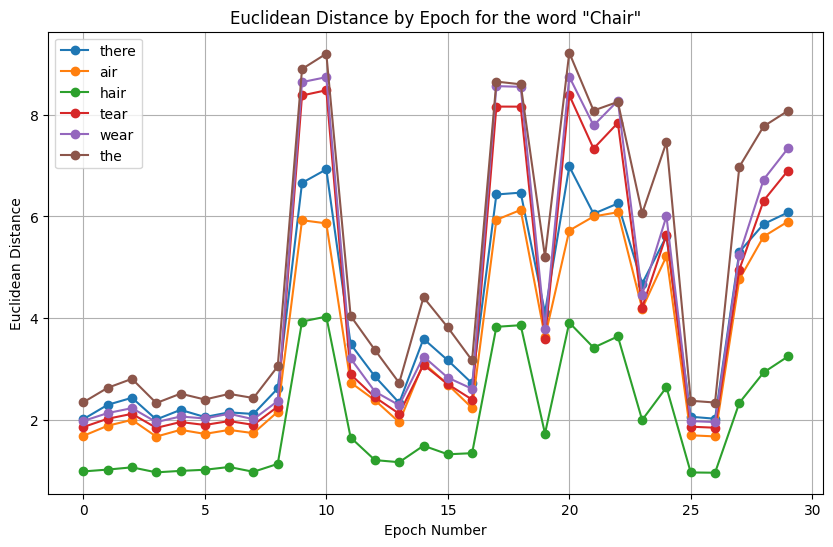

In [54]:
chair_list = []

for rhyme in chair_rhymes:
    for dataframe in pairwise_similarity_matrices_euclidean:
        distance_dict = {
                        "epoch": dataframe['epoch'],
                        "word": rhyme,
                        "distance": distance_between_words('chair' , rhyme, dataframe['distance_matrix']),
                    }
        chair_list.append(distance_dict)

word_data = {}
for item in chair_list:
    if item['word'] not in word_data:
        word_data[item['word']] = {'epochs': [], 'distances': []}
    word_data[item['word']]['epochs'].append(item['epoch'])
    word_data[item['word']]['distances'].append(item['distance'])

# Plotting
plt.figure(figsize=(10, 6))
for word, values in word_data.items():
    plt.plot(values['epochs'], values['distances'], label=word, marker='o')

plt.xlabel('Epoch Number')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance by Epoch for the word "Chair"')
plt.legend()
plt.grid(True)
plt.show()

### Cosine Similarity

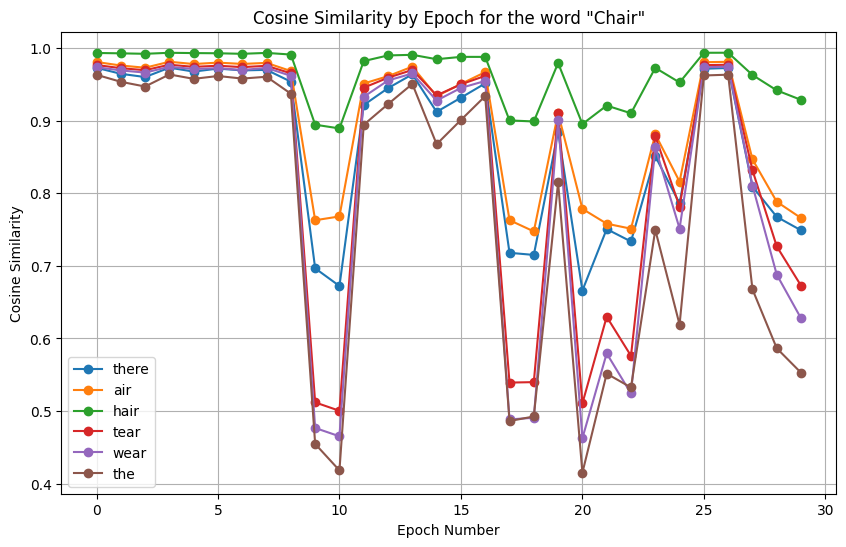

In [55]:
chair_list = []

for rhyme in chair_rhymes:
    for dataframe in pairwise_similarity_matrices_cs:
        distance_dict = {
                        "epoch": dataframe['epoch'],
                        "word": rhyme,
                        "distance": distance_between_words('chair' , rhyme, dataframe['similarity_matrix']),
                    }
        chair_list.append(distance_dict)

word_data = {}
for item in chair_list:
    if item['word'] not in word_data:
        word_data[item['word']] = {'epochs': [], 'distances': []}
    word_data[item['word']]['epochs'].append(item['epoch'])
    word_data[item['word']]['distances'].append(item['distance'])

# Plotting
plt.figure(figsize=(10, 6))
for word, values in word_data.items():
    plt.plot(values['epochs'], values['distances'], label=word, marker='o')

plt.xlabel('Epoch Number')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity by Epoch for the word "Chair"')
plt.legend()
plt.grid(True)
plt.show()

## Analysis of word 'head'

### Euclidean Distance

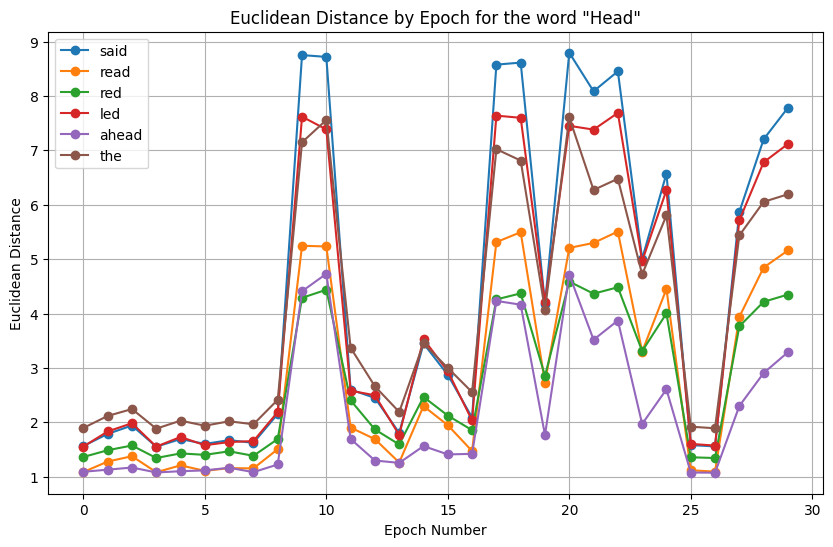

In [56]:
head_list = []

for rhyme in head_rhymes:
    for dataframe in pairwise_similarity_matrices_euclidean:
        distance_dict = {
                        "epoch": dataframe['epoch'],
                        "word": rhyme,
                        "distance": distance_between_words('head' , rhyme, dataframe['distance_matrix']),
                    }
        head_list.append(distance_dict)

word_data = {}
for item in head_list:
    if item['word'] not in word_data:
        word_data[item['word']] = {'epochs': [], 'distances': []}
    word_data[item['word']]['epochs'].append(item['epoch'])
    word_data[item['word']]['distances'].append(item['distance'])

# Plotting
plt.figure(figsize=(10, 6))
for word, values in word_data.items():
    plt.plot(values['epochs'], values['distances'], label=word, marker='o')

plt.xlabel('Epoch Number')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance by Epoch for the word "Head"')
plt.legend()
plt.grid(True)
plt.show()

### Cosine Similarity

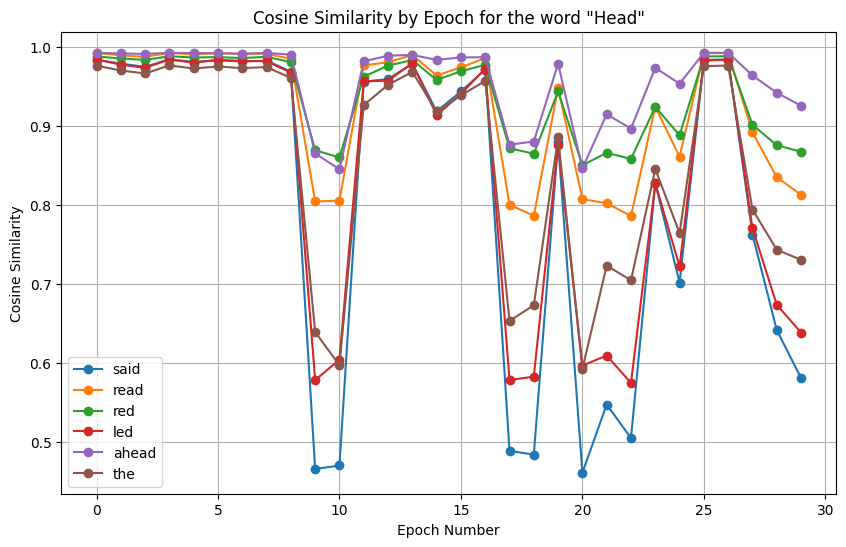

In [57]:
head_list = []

for rhyme in head_rhymes:
    for dataframe in pairwise_similarity_matrices_cs:
        distance_dict = {
                        "epoch": dataframe['epoch'],
                        "word": rhyme,
                        "distance": distance_between_words('head' , rhyme, dataframe['similarity_matrix']),
                    }
        head_list.append(distance_dict)
head_list

word_data = {}
for item in head_list:
    if item['word'] not in word_data:
        word_data[item['word']] = {'epochs': [], 'distances': []}
    word_data[item['word']]['epochs'].append(item['epoch'])
    word_data[item['word']]['distances'].append(item['distance'])

# Plotting
plt.figure(figsize=(10, 6))
for word, values in word_data.items():
    plt.plot(values['epochs'], values['distances'], label=word, marker='o')

plt.xlabel('Epoch Number')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity by Epoch for the word "Head"')
plt.legend()
plt.grid(True)
plt.show()

## Analysis of word 'three'

### Euclidean Distance

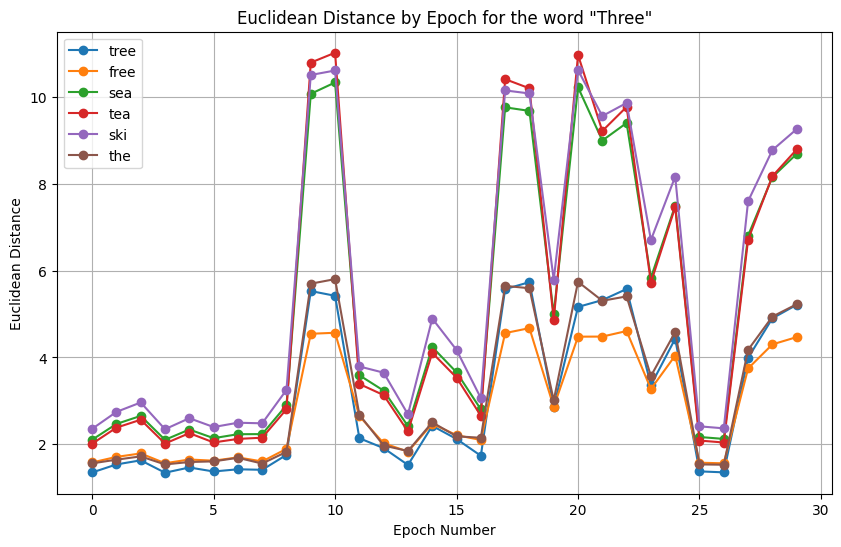

In [58]:
three_list = []

for rhyme in three_rhymes:
    for dataframe in pairwise_similarity_matrices_euclidean:
        distance_dict = {
                        "epoch": dataframe['epoch'],
                        "word": rhyme,
                        "distance": distance_between_words('three' , rhyme, dataframe['distance_matrix']),
                    }
        three_list.append(distance_dict)
three_list

word_data = {}
for item in three_list:
    if item['word'] not in word_data:
        word_data[item['word']] = {'epochs': [], 'distances': []}
    word_data[item['word']]['epochs'].append(item['epoch'])
    word_data[item['word']]['distances'].append(item['distance'])

# Plotting
plt.figure(figsize=(10, 6))
for word, values in word_data.items():
    plt.plot(values['epochs'], values['distances'], label=word, marker='o')

plt.xlabel('Epoch Number')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance by Epoch for the word "Three"')
plt.legend()
plt.grid(True)
plt.show()


### Cosine Similarity

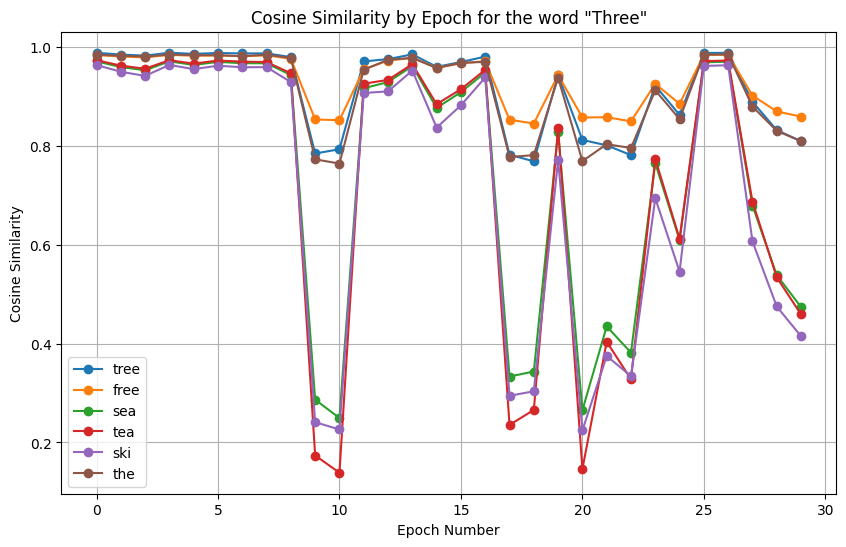

In [59]:
three_list = []

for rhyme in three_rhymes:
    for dataframe in pairwise_similarity_matrices_cs:
        distance_dict = {
                        "epoch": dataframe['epoch'],
                        "word": rhyme,
                        "distance": distance_between_words('three' , rhyme, dataframe['similarity_matrix']),
                    }
        three_list.append(distance_dict)
three_list

word_data = {}
for item in three_list:
    if item['word'] not in word_data:
        word_data[item['word']] = {'epochs': [], 'distances': []}
    word_data[item['word']]['epochs'].append(item['epoch'])
    word_data[item['word']]['distances'].append(item['distance'])

# Plotting
plt.figure(figsize=(10, 6))
for word, values in word_data.items():
    plt.plot(values['epochs'], values['distances'], label=word, marker='o')

plt.xlabel('Epoch Number')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity by Epoch for the word "Three"')
plt.legend()
plt.grid(True)
plt.show()


# Computing the n Nearest Neighbors for each epoch

### Once more, the three examples presented above are taken

## N-Nearest Neighbors, at each epoch, for the word 'Chair'

### Euclidean Distance

In [18]:
chair_nearest_neighbors = []

for matrix in pairwise_similarity_matrices_euclidean:
    chair_nn = nearest_neighbors('chair', 2, matrix['distance_matrix'])
    nn_chair = {
        "epoch" : matrix['epoch'],
        "nearest_neighbors" : chair_nn
    }
    chair_nearest_neighbors.append(nn_chair)

import plotly.express as px
import pandas as pd

rows = []
for entry in chair_nearest_neighbors:
    epoch = entry['epoch']
    for neighbor in entry['nearest_neighbors']:
        rows.append({
            'Epoch': epoch,
            'Distance': neighbor['distance'],
            'Word': neighbor['word_raw']
        })

df = pd.DataFrame(rows)

fig = px.scatter(df, x='Epoch', y='Distance', text='Word', hover_data=['Word'],
                 title='Nearest Neighbors for "Chair" - Eucl. Dist.')
fig.update_traces(marker=dict(size=8),
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.update_yaxes(title='Euclidean Distance')  
fig.show()


### Cosine Similarity

In [19]:
chair_nearest_neighbors = []

for matrix in pairwise_similarity_matrices_cs:
    chair_nn = nearest_neighbors_cosine('chair', 2, matrix['similarity_matrix'])
    nn_chair = {
        "epoch" : matrix['epoch'],
        "nearest_neighbors" : chair_nn
    }
    chair_nearest_neighbors.append(nn_chair)

import plotly.express as px
import pandas as pd

rows = []
for entry in chair_nearest_neighbors:
    epoch = entry['epoch']
    for neighbor in entry['nearest_neighbors']:
        rows.append({
            'Epoch': epoch,
            'Distance': neighbor['similarity'],
            'Word': neighbor['word']
        })

df = pd.DataFrame(rows)

fig = px.scatter(df, x='Epoch', y='Distance', text='Word', hover_data=['Word'],
                 title='Nearest Neighbors for "Chair" - Cos. Sim.')
fig.update_traces(marker=dict(size=8),
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.update_yaxes(title='Cosine Similarity')  

fig.show()


## N-Nearest Neighbors, at each epoch, for the word 'Head'

### Euclidean Distance

In [20]:
head_nearest_neighbors = []

for matrix in pairwise_similarity_matrices_euclidean:
    head_nn = nearest_neighbors('head', 2, matrix['distance_matrix'])
    nn_head = {
        "epoch" : matrix['epoch'],
        "nearest_neighbors" : head_nn
    }
    head_nearest_neighbors.append(nn_head)

import plotly.express as px
import pandas as pd

rows = []
for entry in head_nearest_neighbors:
    epoch = entry['epoch']
    for neighbor in entry['nearest_neighbors']:
        rows.append({
            'Epoch': epoch,
            'Distance': neighbor['distance'],
            'Word': neighbor['word_raw']
        })

df = pd.DataFrame(rows)

fig = px.scatter(df, x='Epoch', y='Distance', text='Word', hover_data=['Word'],
                 title='Nearest Neighbors for "Head" - Eucl. Dist.')
fig.update_traces(marker=dict(size=8),
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.update_yaxes(title='Euclidean Distance')  

fig.show()


### Cosine Similarity

In [21]:
head_nearest_neighbors = []

for matrix in pairwise_similarity_matrices_cs:
    head_nn = nearest_neighbors_cosine('head', 2, matrix['similarity_matrix'])
    nn_head = {
        "epoch" : matrix['epoch'],
        "nearest_neighbors" : head_nn
    }
    head_nearest_neighbors.append(nn_head)

import plotly.express as px
import pandas as pd

rows = []
for entry in head_nearest_neighbors:
    epoch = entry['epoch']
    for neighbor in entry['nearest_neighbors']:
        rows.append({
            'Epoch': epoch,
            'Distance': neighbor['similarity'],
            'Word': neighbor['word']
        })

df = pd.DataFrame(rows)

fig = px.scatter(df, x='Epoch', y='Distance', text='Word', hover_data=['Word'],
                 title='Nearest Neighbors for "Head" - Cos. Sim.')
fig.update_traces(marker=dict(size=8),
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.update_yaxes(title='Cosine Similarity')  

fig.show()


## N-Nearest Neighbors, at each epoch, for the word 'Three'

### Euclidean Distance

In [22]:
three_nearest_neighbors = []

for matrix in pairwise_similarity_matrices_euclidean:
    three_nn = nearest_neighbors('three', 2, matrix['distance_matrix'])
    nn_three = {
        "epoch" : matrix['epoch'],
        "nearest_neighbors" : three_nn
    }
    three_nearest_neighbors.append(nn_three)

import plotly.express as px
import pandas as pd

rows = []
for entry in three_nearest_neighbors:
    epoch = entry['epoch']
    for neighbor in entry['nearest_neighbors']:
        rows.append({
            'Epoch': epoch,
            'Distance': neighbor['distance'],
            'Word': neighbor['word_raw']
        })

df = pd.DataFrame(rows)

fig = px.scatter(df, x='Epoch', y='Distance', text='Word', hover_data=['Word'],
                 title='Nearest Neighbors for "Three" - Eucl. Dist.')
fig.update_traces(marker=dict(size=8),
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.update_yaxes(title='Euclidean Distance')  

fig.show()


### Cosine Similarity

In [23]:
three_nearest_neighbors = []

for matrix in pairwise_similarity_matrices_cs:
    three_nn = nearest_neighbors_cosine('three', 2, matrix['similarity_matrix'])
    nn_three = {
        "epoch" : matrix['epoch'],
        "nearest_neighbors" : three_nn
    }
    three_nearest_neighbors.append(nn_three)

import plotly.express as px
import pandas as pd

rows = []
for entry in three_nearest_neighbors:
    epoch = entry['epoch']
    for neighbor in entry['nearest_neighbors']:
        rows.append({
            'Epoch': epoch,
            'Distance': neighbor['similarity'],
            'Word': neighbor['word']
        })

df = pd.DataFrame(rows)

fig = px.scatter(df, x='Epoch', y='Distance', text='Word', hover_data=['Word'],
                 title='Nearest Neighbors for "Three" - Cos. Sim.')
fig.update_traces(marker=dict(size=8),
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.update_yaxes(title='Cosine Similarity')  

fig.show()


# Taking Minimum and Average Euclidean Distance / Maximum and Average Cosine Similarity at each epoch and comparing it. 

### Minimum Euclidean Distance

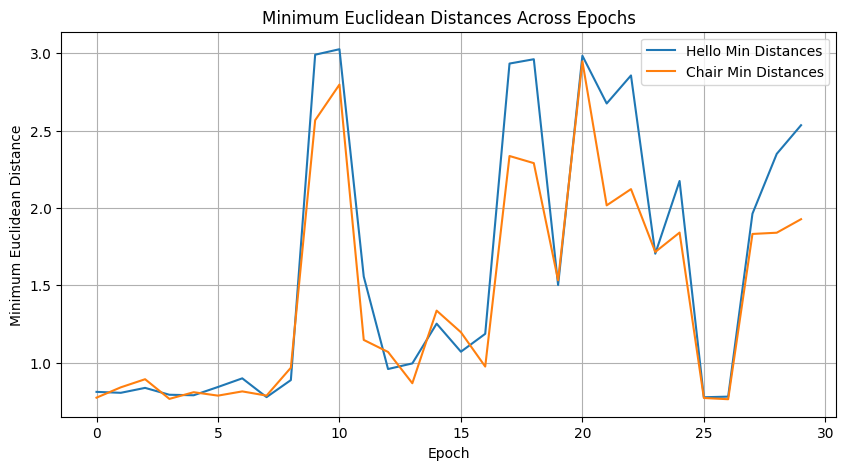

In [24]:
import numpy as np
import matplotlib.pyplot as plt

hello_minimum_distances_euclidean = []
chair_minimum_distances_euclidean = []
epochs = []

for index, matrix in enumerate(pairwise_similarity_matrices_euclidean):
    test = matrix['distance_matrix']
    np.fill_diagonal(test.values, np.nan)  
    hello_minimum = test['hello'].min()
    chair_minimum = test['chair'].min()
    
    hello_minimum_distances_euclidean.append(hello_minimum)
    chair_minimum_distances_euclidean.append(chair_minimum)
    epochs.append(index)

plt.figure(figsize=(10, 5))
plt.plot(epochs, hello_minimum_distances_euclidean, label='Hello Min Distances')
plt.plot(epochs, chair_minimum_distances_euclidean, label='Chair Min Distances')
plt.xlabel('Epoch')
plt.ylabel('Minimum Euclidean Distance')
plt.title('Minimum Euclidean Distances Across Epochs')
plt.legend()
plt.grid(True)
plt.show()



### Average Euclidean Distance

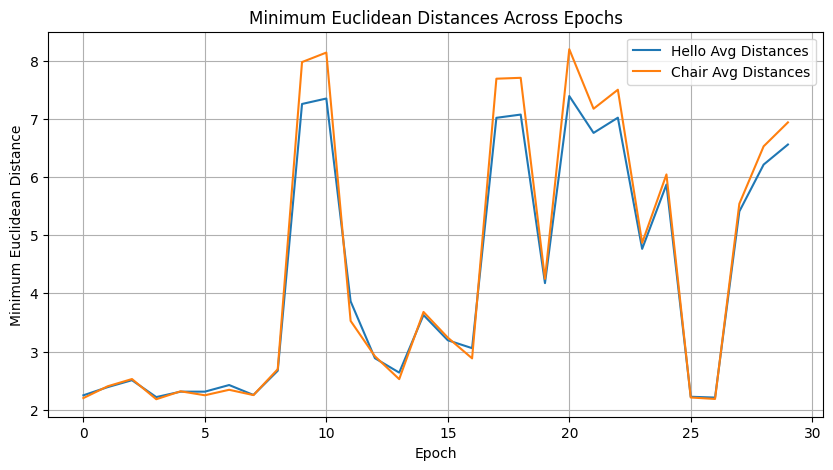

In [25]:
import numpy as np
import matplotlib.pyplot as plt

hello_minimum_distances_euclidean = []
chair_minimum_distances_euclidean = []
epochs = []

for index, matrix in enumerate(pairwise_similarity_matrices_euclidean):
    test = matrix['distance_matrix']
    np.fill_diagonal(test.values, np.nan)  
    hello_minimum = test['hello'].mean()
    chair_minimum = test['chair'].mean()
    
    hello_minimum_distances_euclidean.append(hello_minimum)
    chair_minimum_distances_euclidean.append(chair_minimum)
    epochs.append(index)

plt.figure(figsize=(10, 5))
plt.plot(epochs, hello_minimum_distances_euclidean, label='Hello Avg Distances')
plt.plot(epochs, chair_minimum_distances_euclidean, label='Chair Avg Distances')
plt.xlabel('Epoch')
plt.ylabel('Average Euclidean Distance')
plt.title('Average Euclidean Distances Across Epochs')
plt.legend()
plt.grid(True)
plt.show()



### Maximum Cosine Similarity

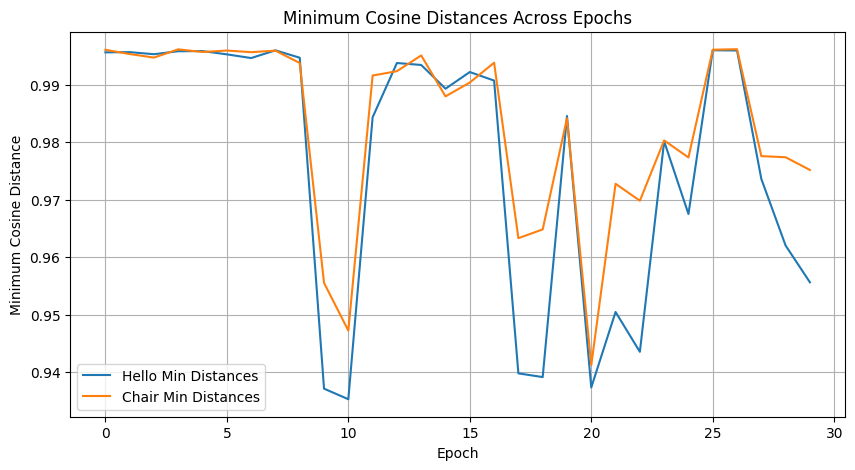

In [26]:
import numpy as np
import matplotlib.pyplot as plt

hello_minimum_distances_euclidean = []
chair_minimum_distances_euclidean = []
epochs = []

for index, matrix in enumerate(pairwise_similarity_matrices_cs):
    test = matrix['similarity_matrix']
    np.fill_diagonal(test.values, np.nan)  
    hello_minimum = test['hello'].max()
    chair_minimum = test['chair'].max()
    
    hello_minimum_distances_euclidean.append(hello_minimum)
    chair_minimum_distances_euclidean.append(chair_minimum)
    epochs.append(index)

plt.figure(figsize=(10, 5))
plt.plot(epochs, hello_minimum_distances_euclidean, label='Hello Min Distances')
plt.plot(epochs, chair_minimum_distances_euclidean, label='Chair Min Distances')
plt.xlabel('Epoch')
plt.ylabel('Minimum Cosine Distance')
plt.title('Minimum Cosine Distances Across Epochs')
plt.legend()
plt.grid(True)
plt.show()



### Average Cosine Similarity

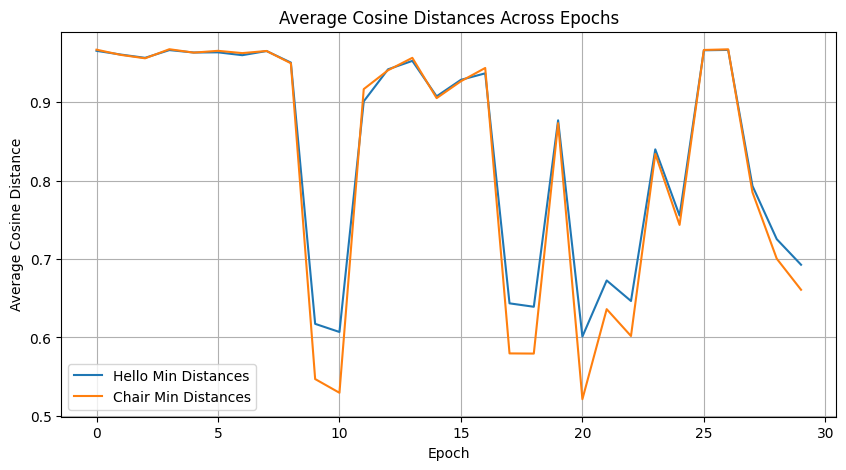

In [27]:
import numpy as np
import matplotlib.pyplot as plt

hello_minimum_distances_euclidean = []
chair_minimum_distances_euclidean = []
epochs = []

for index, matrix in enumerate(pairwise_similarity_matrices_cs):
    test = matrix['similarity_matrix']
    np.fill_diagonal(test.values, np.nan)  
    hello_minimum = test['hello'].mean()
    chair_minimum = test['chair'].mean()
    
    hello_minimum_distances_euclidean.append(hello_minimum)
    chair_minimum_distances_euclidean.append(chair_minimum)
    epochs.append(index)

plt.figure(figsize=(10, 5))
plt.plot(epochs, hello_minimum_distances_euclidean, label='Hello Min Distances')
plt.plot(epochs, chair_minimum_distances_euclidean, label='Chair Min Distances')
plt.xlabel('Epoch')
plt.ylabel('Average Cosine Distance')
plt.title('Average Cosine Distances Across Epochs')
plt.legend()
plt.grid(True)
plt.show()



## Review Conclusions - 08/23/2024

### Cosine Similarity
When utilizing pairwise distance matrices obtained from using COSINE SIMILARITY, the resulting Nearest Neighbors are words that I do not intuitively think of. By this, I intend to say that these are words that I would not associate, both semantically nor gramatically. For example, when analyzing the Nearest neighbors, at each epoch, for the words 'hello' and 'chair', 'hello' has, as the top 2 nearest neighbors in the latest epochs 'am' and 'mam', while chair has 'so' and 'mom'. 

### Euclidean Distance
Contrarily, when analyzing the nearest neighbor words when utilizing pairwise distance matrices obtained from using EUCLIDEAN DISTANCE, the NN words are somewhat expected. For 'hello', the framework returns 'shell' or 'cell'. 

### The main difference
What I believe the main difference between the 2 to be is their respective Minimum Distance across epochs. Euclidean distance has more intuitive neighbors, however their distances increase over the epochs.
Cosine similarity behaves in the opposite way, the NNs are not as intuitive, however their distance does decrease over the epochs. 

### Area of the code to research
The code remains the same in both the areas, and can work in both the areas. In both instances, it looks for the MINIMUM distance, and for both cosine distance and euclidean distance that is exactly what we are looking for. The other possible area to look into is directly to the pairwise distance creation.


# Checking if all embeddings were initialized close to each other.
### Checking first epoch, and comparing it to 15th epoch, and to third epoch in a 3D graph

In [28]:
base_name='giuliomartini_2024-06-28_14h23m56350ms_chkpt'
folder_path = '/Users/giuliomartini/Desktop/FSU/BRIDGE/BRIDGE/models'
dimensions=64

csv_files = glob.glob(folder_path + '/' + base_name + '*.csv')  # Make sure to match the pattern
dataframes = [pd.read_csv(file) for file in csv_files]

## Analyze raw embeddings related values
### Plot Average Magnitude over the Epochs
### Plot Average Variance in the Embeddings over the Embeddings

### Why are we analyzing the variance and average magnitude of the embeddings over the epochs?
As we have seen above, the values for both cosine similarity and euclidean distance both have massive shifts in values during the course of training. All three examples, however, follow a specific pattern for both the distance and similarity measure. Analyzing how the variance changed over epochs can tell help us explain the big spikes and dips in similarity/distance, as all of the words are getting more/less distant.
This analysis is crucial for several reasons:

- **Model Stability and Convergence**: 
Variance in the magnitude of embeddings can indicate how stable the learning process is. A decreasing variance over epochs might suggest that the model is converging to a stable set of parameters. Conversely, high or increasing variance could indicate ongoing learning or instability in the model. This can be particularly important in deciding when a model has learned sufficiently or requires adjustments in its training regimen.

- **Understanding Embedding Evolution**: 
By tracking the average magnitude and variance of embeddings, we can gain insights into how the semantic space defined by the embeddings evolves. For instance, if embeddings are becoming more spread out (higher variance), it might mean that the model is better capturing the diversity of contexts and meanings in the data. If embeddings are clustering closer together (lower variance), it might suggest that the model is focusing on common or general features across words.

- **Algorithmic Insights**: Observing how embeddings change can also provide insights into the behavior of the underlying algorithms, such as the effects of learning rates, batch sizes, or specific regularization techniques. This can guide further improvements in model architecture or training approaches.

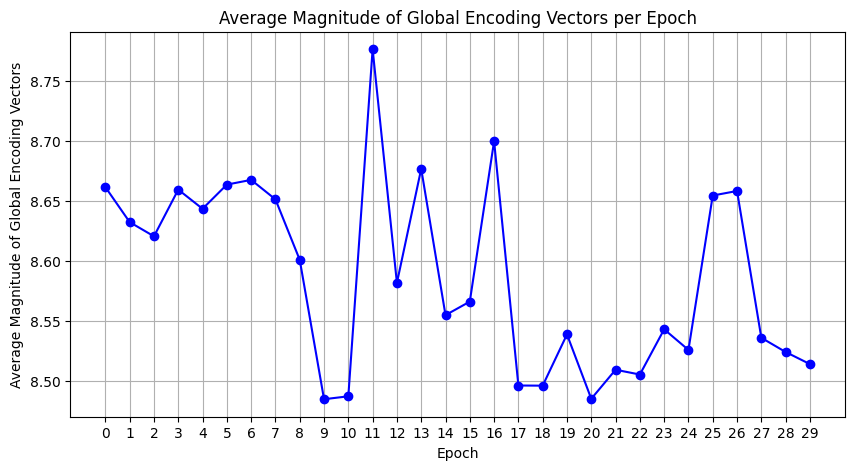

In [31]:
def process_encoding(encoding):
    return np.array([float(x) for x in encoding.split(':')])

def calculate_average_magnitudes(dataframes):
    average_magnitudes = []
    
    for epoch_index, df in enumerate(dataframes):
        df['vector'] = df['global_encoding'].apply(process_encoding)
        df['magnitude'] = df['vector'].apply(np.linalg.norm)
        average_magnitude = df['magnitude'].mean()
        average_magnitudes.append(average_magnitude)
    
    return average_magnitudes


average_magnitudes = calculate_average_magnitudes(dataframes)

epochs = list(range(0, 30))  
plt.figure(figsize=(10, 5))
plt.plot(epochs, average_magnitudes, marker='o', linestyle='-', color='b')
plt.title('Average Magnitude of Global Encoding Vectors per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Magnitude of Global Encoding Vectors')
plt.grid(True)
plt.xticks(epochs)  
plt.show()


In [32]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd

# Function Definitions (Assuming these are already defined and working as intended)
def process_encoding(encoding):
    return np.array([float(x) for x in encoding.split(':')])

def calculate_statistics(dataframes):
    average_magnitudes = []
    variances = []
    for epoch_index, df in enumerate(dataframes):
        df['vector'] = df['global_encoding'].apply(process_encoding)
        df['magnitude'] = df['vector'].apply(np.linalg.norm)
        average_magnitude = df['magnitude'].mean()
        variance = df['magnitude'].var()
        average_magnitudes.append(average_magnitude)
        variances.append(variance)
    return average_magnitudes, variances

# Assuming 'dataframes' is a list of 30 DataFrame objects for each epoch
average_magnitudes, variances = calculate_statistics(dataframes)
epochs = list(range(1, 31))

# Calculation of minimum distances for 'hello' and 'chair'
hello_minimum_distances_euclidean = []
chair_minimum_distances_euclidean = []
for index, matrix in enumerate(pairwise_similarity_matrices_euclidean):
    test = matrix['distance_matrix']
    np.fill_diagonal(test.values, np.nan)  
    hello_minimum = test['hello'].mean()
    chair_minimum = test['chair'].mean()
    hello_minimum_distances_euclidean.append(hello_minimum)
    chair_minimum_distances_euclidean.append(chair_minimum)

# Creating subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Average Magnitude of Vectors per Epoch", "Variance of Magnitudes per Epoch",
                    "Avergae Euclidean Distances Across Epochs"),
    specs=[[{}, {}], [{"colspan": 2}, None]]
)

# Adding traces
fig.add_trace(
    go.Scatter(x=epochs, y=average_magnitudes, mode='lines+markers', name='Average Magnitude'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=epochs, y=variances, mode='lines+markers', name='Variance'),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=epochs, y=hello_minimum_distances_euclidean, mode='lines+markers', name='Hello - Word Average Distances', line=dict(color='green')),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=epochs, y=chair_minimum_distances_euclidean, mode='lines+markers', name='Chair - Word Average Distances', line=dict(color='purple')),
    row=2, col=1
)

# Updating layout
fig.update_layout(height=800, width=1000, title_text="Vector Analysis Across Epochs")
fig.show()


In [33]:
import numpy as np
import pandas as pd

def process_encoding(encoding):
    return np.array([float(x) for x in encoding.split(':')])

def normalize_vector(vector):
    norm = np.linalg.norm(vector)
    if norm == 0: 
        return vector  # Handles zero vector
    return vector / norm

def apply_normalization(df):
    df['vector'] = df['global_encoding'].apply(process_encoding)
    df['normalized_vector'] = df['vector'].apply(normalize_vector)
    return df

# Assuming you have a list of DataFrames: dataframes = [df1, df2, ..., df30]
normalized_dataframes = []

for index, df in enumerate(dataframes, start=0):
    normalized_df = apply_normalization(df)
    normalized_dataframes.append(normalized_df)
    
    # Save each DataFrame to a CSV file
    filename = f'/Users/giuliomartini/Desktop/FSU/BRIDGE/normalized/normalized_dataframe_epoch_{index}.csv'
    normalized_df.to_csv(filename, index=False)
    print(f'Saved normalized DataFrame for epoch {index} to "{filename}"')


Saved normalized DataFrame for epoch 0 to "/Users/giuliomartini/Desktop/FSU/BRIDGE/normalized/normalized_dataframe_epoch_0.csv"
Saved normalized DataFrame for epoch 1 to "/Users/giuliomartini/Desktop/FSU/BRIDGE/normalized/normalized_dataframe_epoch_1.csv"
Saved normalized DataFrame for epoch 2 to "/Users/giuliomartini/Desktop/FSU/BRIDGE/normalized/normalized_dataframe_epoch_2.csv"
Saved normalized DataFrame for epoch 3 to "/Users/giuliomartini/Desktop/FSU/BRIDGE/normalized/normalized_dataframe_epoch_3.csv"
Saved normalized DataFrame for epoch 4 to "/Users/giuliomartini/Desktop/FSU/BRIDGE/normalized/normalized_dataframe_epoch_4.csv"
Saved normalized DataFrame for epoch 5 to "/Users/giuliomartini/Desktop/FSU/BRIDGE/normalized/normalized_dataframe_epoch_5.csv"
Saved normalized DataFrame for epoch 6 to "/Users/giuliomartini/Desktop/FSU/BRIDGE/normalized/normalized_dataframe_epoch_6.csv"
Saved normalized DataFrame for epoch 7 to "/Users/giuliomartini/Desktop/FSU/BRIDGE/normalized/normalized

## Recomputing Distance Matrices with Normalized CSVs

### Euclidean

In [34]:
def compute_distance_matrices_euclidean_normalized(base_name: str, folder_path: str, dimensions: int):
    # Using glob to find all CSV files that match the base name pattern
    csv_files = glob.glob(f'{folder_path}/{base_name}*.csv')
    dataframes = [pd.read_csv(file) for file in csv_files]
    print(dataframes)
    pairwise_distances = []

    # Process each DataFrame
    for index, dataframe in enumerate(dataframes):
        # Split the 'global_encoding' column into separate columns for each dimension
        split_columns = dataframe['global_encoding'].str.split(':', expand=True)
        split_columns.columns = [f'dim_{i+1}' for i in range(dimensions)]  # Rename columns to represent each dimension

        # Combine with the 'word_raw' column for easy reference
        new_df = pd.concat([dataframe[['word_raw']], split_columns], axis=1)
        
        # Convert all dimension columns to numeric
        new_df[split_columns.columns] = new_df[split_columns.columns].apply(pd.to_numeric, errors='coerce')

        # Extract the embeddings as a numpy array
        embeddings = new_df[split_columns.columns].to_numpy()

        # Compute Euclidean distances between all pairs of vectors
        euclidean_distances = cdist(embeddings, embeddings, 'euclidean')

        # Create a DataFrame from the distances with words as both row and column indices
        distance_df = pd.DataFrame(euclidean_distances, index=new_df['word_raw'], columns=new_df['word_raw'])

        # Store the distance matrix with the epoch index
        epoch_dict = {
            'epoch': index,
            'distance_matrix': distance_df
        }
        pairwise_distances.append(epoch_dict)

    return pairwise_distances

normalized_pairwise_distance_matrices = compute_distance_matrices_euclidean_normalized("normalized_dataframe_epoch_", "/Users/giuliomartini/Desktop/FSU/BRIDGE/normalized/", 64)

[     word_raw     phon_target  \
0       three        TH:R:IY1   
1        been         B:IH1:N   
2     message  M:EH1:S:AH0:JH   
3        knob         N:AA1:B   
4         god         G:AA1:D   
...       ...             ...   
3613  digging  D:IH1:G:IH0:NG   
3614     dear         D:IH1:R   
3615     pups       P:AH1:P:S   
3616    finds     F:AY1:N:D:Z   
3617   paying    P:EY1:IH0:NG   

                                        phon_prediction  correct  \
0     None:None:None:%:None:%:None:None:None:None:No...    False   
1     None:None:None:%:None:%:None:%:None:None:None:...    False   
2     None:None:None:None:None:None:None:None:None:N...    False   
3     None:None:None:None:%:None:None:None:None:None...    False   
4     None:None:None:%:%:None:None:%:None:None:None:...    False   
...                                                 ...      ...   
3613  None:None:None:None:None:None:None:None:None:N...    False   
3614  None:None:D:%:None:None:None:None:None:None:No...   

### Cosine

In [35]:
import glob
import pandas as pd
from scipy.spatial.distance import cdist

def compute_distance_matrices_cosine_normalized(base_name: str, folder_path: str, dimensions: int):
    # Using glob to find all CSV files that match the base name pattern
    csv_files = glob.glob(f'{folder_path}/{base_name}*.csv')
    dataframes = [pd.read_csv(file) for file in csv_files]
    print(dataframes)
    pairwise_distances = []

    # Process each DataFrame
    for index, dataframe in enumerate(dataframes):
        # Split the 'global_encoding' column into separate columns for each dimension
        split_columns = dataframe['global_encoding'].str.split(':', expand=True)
        split_columns.columns = [f'dim_{i+1}' for i in range(dimensions)]  # Rename columns to represent each dimension

        # Combine with the 'word_raw' column for easy reference
        new_df = pd.concat([dataframe[['word_raw']], split_columns], axis=1)
        
        # Convert all dimension columns to numeric
        new_df[split_columns.columns] = new_df[split_columns.columns].apply(pd.to_numeric, errors='coerce')

        # Extract the embeddings as a numpy array
        embeddings = new_df[split_columns.columns].to_numpy()

        # Compute Euclidean distances between all pairs of vectors
        euclidean_distances = cdist(embeddings, embeddings, 'cosine')

        # Create a DataFrame from the distances with words as both row and column indices
        distance_df = pd.DataFrame(euclidean_distances, index=new_df['word_raw'], columns=new_df['word_raw'])

        # Store the distance matrix with the epoch index
        epoch_dict = {
            'epoch': index,
            'distance_matrix': distance_df
        }
        pairwise_distances.append(epoch_dict)

    return pairwise_distances

normalized_pairwise_distance_matrices_cosine = compute_distance_matrices_cosine_normalized("normalized_dataframe_epoch_", "/Users/giuliomartini/Desktop/FSU/BRIDGE/normalized/", 64)

[     word_raw     phon_target  \
0       three        TH:R:IY1   
1        been         B:IH1:N   
2     message  M:EH1:S:AH0:JH   
3        knob         N:AA1:B   
4         god         G:AA1:D   
...       ...             ...   
3613  digging  D:IH1:G:IH0:NG   
3614     dear         D:IH1:R   
3615     pups       P:AH1:P:S   
3616    finds     F:AY1:N:D:Z   
3617   paying    P:EY1:IH0:NG   

                                        phon_prediction  correct  \
0     None:None:None:%:None:%:None:None:None:None:No...    False   
1     None:None:None:%:None:%:None:%:None:None:None:...    False   
2     None:None:None:None:None:None:None:None:None:N...    False   
3     None:None:None:None:%:None:None:None:None:None...    False   
4     None:None:None:%:%:None:None:%:None:None:None:...    False   
...                                                 ...      ...   
3613  None:None:None:None:None:None:None:None:None:N...    False   
3614  None:None:D:%:None:None:None:None:None:None:No...   

## Calculating both Cosine Similarity and Euclidean Distance for the Normalized datasets

## Analysis for the word 'Chair'

### Euclidean Distance

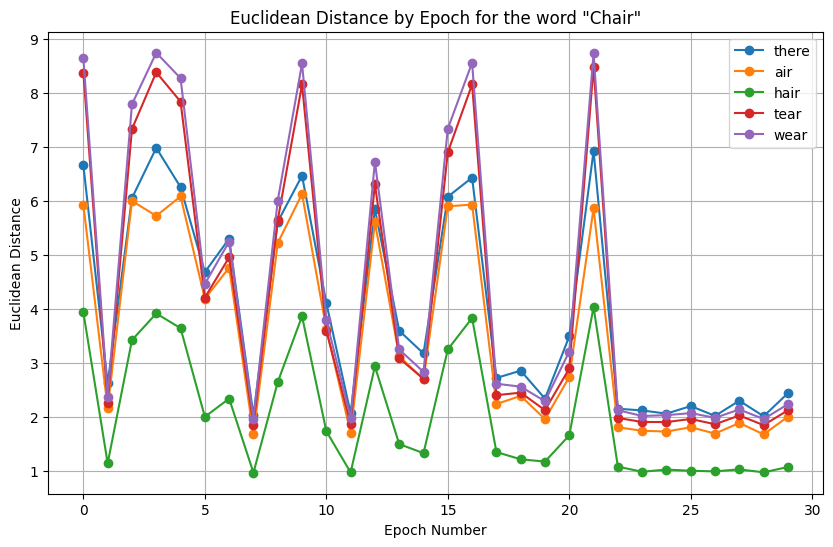

In [36]:
chair_list = []

for rhyme in chair_rhymes:
    for dataframe in normalized_pairwise_distance_matrices:
        distance_dict = {
                        "epoch": dataframe['epoch'],
                        "word": rhyme,
                        "distance": distance_between_words('chair' , rhyme, dataframe['distance_matrix']),
                    }
        chair_list.append(distance_dict)

word_data = {}
for item in chair_list:
    if item['word'] not in word_data:
        word_data[item['word']] = {'epochs': [], 'distances': []}
    word_data[item['word']]['epochs'].append(item['epoch'])
    word_data[item['word']]['distances'].append(item['distance'])

# Plotting
plt.figure(figsize=(10, 6))
for word, values in word_data.items():
    plt.plot(values['epochs'], values['distances'], label=word, marker='o')

plt.xlabel('Epoch Number')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance by Epoch for the word "Chair"')
plt.legend()
plt.grid(True)
plt.show()

### Cosine Similarity

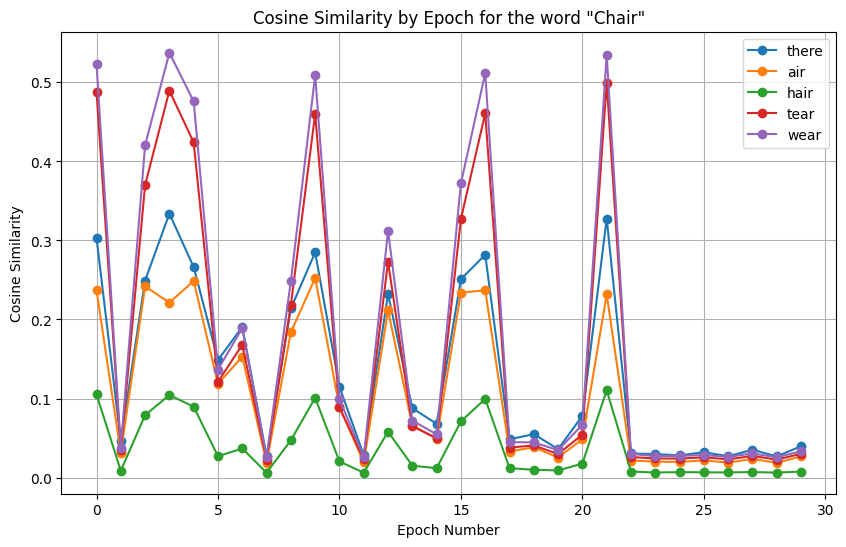

In [37]:
chair_list = []

for rhyme in chair_rhymes:
    for dataframe in normalized_pairwise_distance_matrices_cosine:
        distance_dict = {
                        "epoch": dataframe['epoch'],
                        "word": rhyme,
                        "distance": distance_between_words('chair' , rhyme, dataframe['distance_matrix']),
                    }
        chair_list.append(distance_dict)

word_data = {}
for item in chair_list:
    if item['word'] not in word_data:
        word_data[item['word']] = {'epochs': [], 'distances': []}
    word_data[item['word']]['epochs'].append(item['epoch'])
    word_data[item['word']]['distances'].append(item['distance'])

# Plotting
plt.figure(figsize=(10, 6))
for word, values in word_data.items():
    plt.plot(values['epochs'], values['distances'], label=word, marker='o')

plt.xlabel('Epoch Number')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity by Epoch for the word "Chair"')
plt.legend()
plt.grid(True)
plt.show()

## Analysis for the word 'head'

### Euclidean Distance

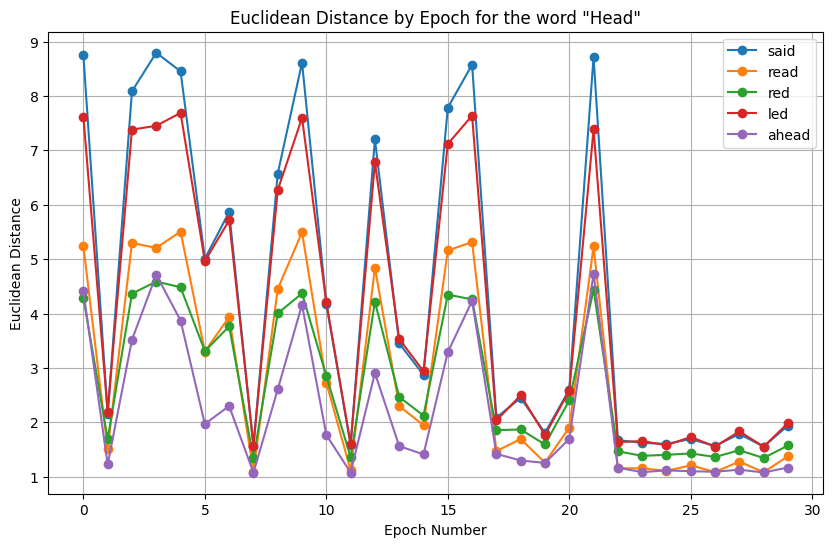

In [38]:
head_list = []

for rhyme in head_rhymes:
    for dataframe in normalized_pairwise_distance_matrices:
        distance_dict = {
                        "epoch": dataframe['epoch'],
                        "word": rhyme,
                        "distance": distance_between_words('head' , rhyme, dataframe['distance_matrix']),
                    }
        head_list.append(distance_dict)

word_data = {}
for item in head_list:
    if item['word'] not in word_data:
        word_data[item['word']] = {'epochs': [], 'distances': []}
    word_data[item['word']]['epochs'].append(item['epoch'])
    word_data[item['word']]['distances'].append(item['distance'])

# Plotting
plt.figure(figsize=(10, 6))
for word, values in word_data.items():
    plt.plot(values['epochs'], values['distances'], label=word, marker='o')

plt.xlabel('Epoch Number')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance by Epoch for the word "Head"')
plt.legend()
plt.grid(True)
plt.show()

### Cosine Similarity

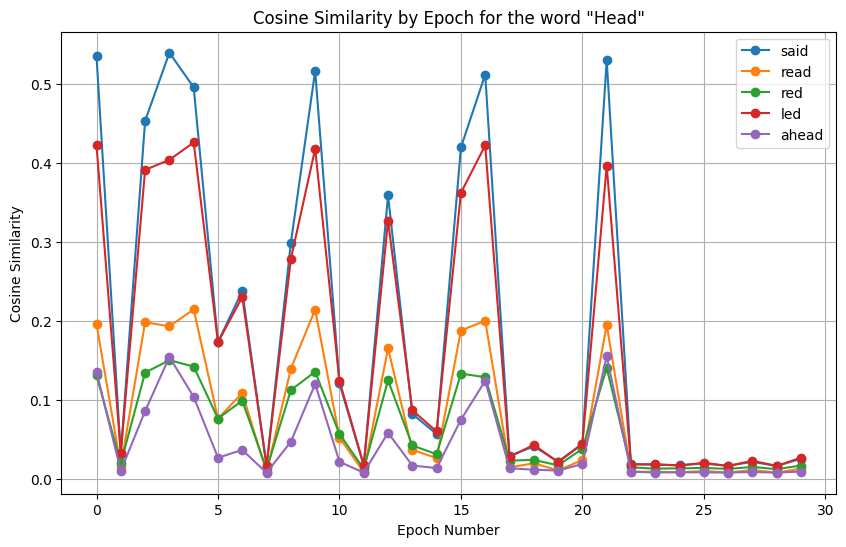

In [39]:
head_list = []

for rhyme in head_rhymes:
    for dataframe in normalized_pairwise_distance_matrices_cosine:
        distance_dict = {
                        "epoch": dataframe['epoch'],
                        "word": rhyme,
                        "distance": distance_between_words('head' , rhyme, dataframe['distance_matrix']),
                    }
        head_list.append(distance_dict)

word_data = {}
for item in head_list:
    if item['word'] not in word_data:
        word_data[item['word']] = {'epochs': [], 'distances': []}
    word_data[item['word']]['epochs'].append(item['epoch'])
    word_data[item['word']]['distances'].append(item['distance'])

# Plotting
plt.figure(figsize=(10, 6))
for word, values in word_data.items():
    plt.plot(values['epochs'], values['distances'], label=word, marker='o')

plt.xlabel('Epoch Number')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity by Epoch for the word "Head"')
plt.legend()
plt.grid(True)
plt.show()

## Analysis for the word 'Three'

### Euclidean Distance

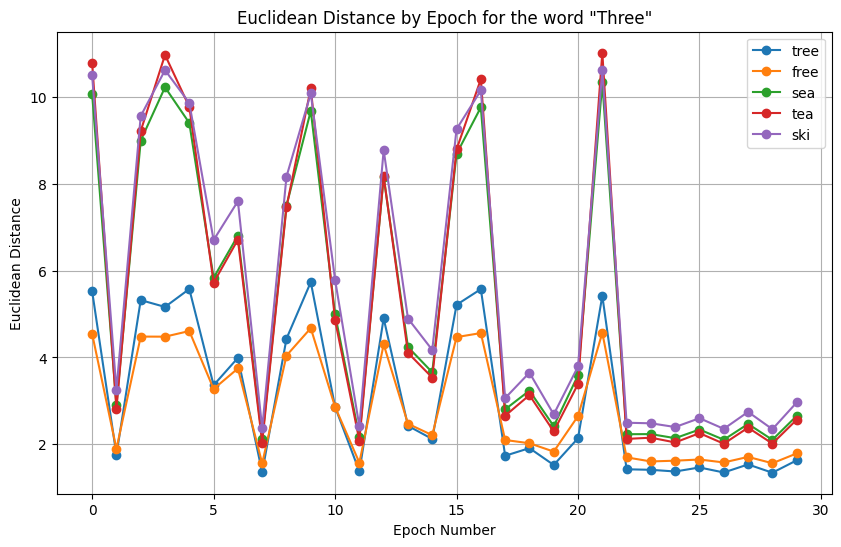

In [40]:
three_list = []

for rhyme in three_rhymes:
    for dataframe in normalized_pairwise_distance_matrices:
        distance_dict = {
                        "epoch": dataframe['epoch'],
                        "word": rhyme,
                        "distance": distance_between_words('three' , rhyme, dataframe['distance_matrix']),
                    }
        three_list.append(distance_dict)
three_list

word_data = {}
for item in three_list:
    if item['word'] not in word_data:
        word_data[item['word']] = {'epochs': [], 'distances': []}
    word_data[item['word']]['epochs'].append(item['epoch'])
    word_data[item['word']]['distances'].append(item['distance'])

# Plotting
plt.figure(figsize=(10, 6))
for word, values in word_data.items():
    plt.plot(values['epochs'], values['distances'], label=word, marker='o')

plt.xlabel('Epoch Number')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance by Epoch for the word "Three"')
plt.legend()
plt.grid(True)
plt.show()


### Cosine Similarity

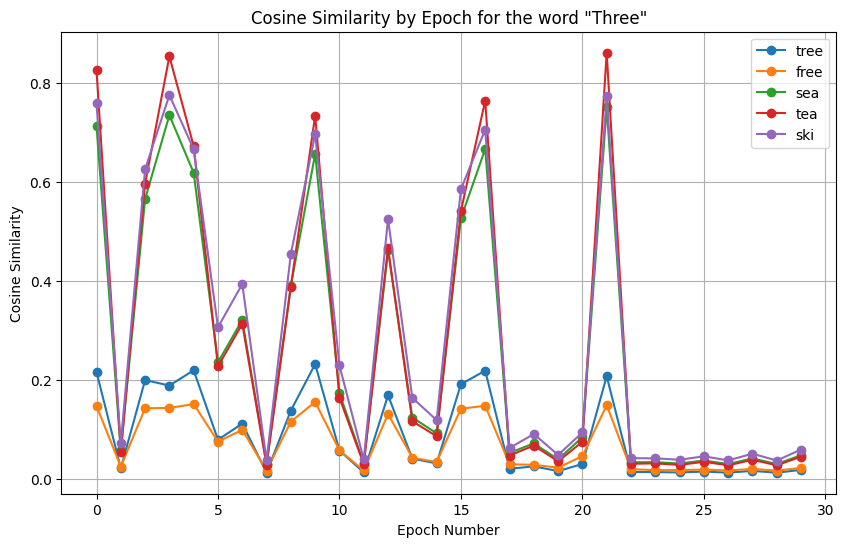

In [41]:
three_list = []

for rhyme in three_rhymes:
    for dataframe in normalized_pairwise_distance_matrices_cosine:
        distance_dict = {
                        "epoch": dataframe['epoch'],
                        "word": rhyme,
                        "distance": distance_between_words('three' , rhyme, dataframe['distance_matrix']),
                    }
        three_list.append(distance_dict)
three_list

word_data = {}
for item in three_list:
    if item['word'] not in word_data:
        word_data[item['word']] = {'epochs': [], 'distances': []}
    word_data[item['word']]['epochs'].append(item['epoch'])
    word_data[item['word']]['distances'].append(item['distance'])

# Plotting
plt.figure(figsize=(10, 6))
for word, values in word_data.items():
    plt.plot(values['epochs'], values['distances'], label=word, marker='o')

plt.xlabel('Epoch Number')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity by Epoch for the word "Three"')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd

folder_path = "/Users/giuliomartini/Desktop/FSU/BRIDGE/normalized/"
base_name = "normalized_dataframe_epoch_"

csv_files = glob.glob(f'{folder_path}/{base_name}*.csv')
dataframes = [pd.read_csv(file) for file in csv_files]

# Function Definitions (Assuming these are already defined and working as intended)
def process_encoding(encoding):
    return np.array([float(x) for x in encoding.split(':')])

def calculate_statistics(dataframes):
    average_magnitudes = []
    variances = []
    for epoch_index, df in enumerate(dataframes):
        df['vector'] = df['global_encoding'].apply(process_encoding)
        df['magnitude'] = df['vector'].apply(np.linalg.norm)
        average_magnitude = df['magnitude'].mean()
        variance = df['magnitude'].var()
        average_magnitudes.append(average_magnitude)
        variances.append(variance)
    return average_magnitudes, variances

# Assuming 'dataframes' is a list of 30 DataFrame objects for each epoch
average_magnitudes, variances = calculate_statistics(dataframes)
epochs = list(range(1, 31))

# Calculation of minimum distances for 'hello' and 'chair'
hello_minimum_distances_euclidean = []
chair_minimum_distances_euclidean = []
for index, matrix in enumerate(pairwise_similarity_matrices_euclidean):
    test = matrix['distance_matrix']
    np.fill_diagonal(test.values, np.nan)  
    hello_minimum = test['hello'].mean()
    chair_minimum = test['chair'].mean()
    hello_minimum_distances_euclidean.append(hello_minimum)
    chair_minimum_distances_euclidean.append(chair_minimum)

# Creating subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Average Magnitude of Vectors per Epoch", "Variance of Magnitudes per Epoch",
                    "Avergae Euclidean Distances Across Epochs"),
    specs=[[{}, {}], [{"colspan": 2}, None]]
)

# Adding traces
fig.add_trace(
    go.Scatter(x=epochs, y=average_magnitudes, mode='lines+markers', name='Average Magnitude'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=epochs, y=variances, mode='lines+markers', name='Variance'),
    row=1, col=2
)


# Updating layout
fig.update_layout(height=800, width=1000, title_text="Vector Analysis Across Epochs")
fig.show()


In [52]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.impute import SimpleImputer

# Helper function to perform clustering and visualization
def cluster_and_visualize(epoch_data, kmeans_init=None):
    embeddings = epoch_data.values
    words = epoch_data.index

    # Handle NaN values
    imputer = SimpleImputer(strategy='mean')
    embeddings_imputed = imputer.fit_transform(embeddings)

    # K-means Clustering
    if kmeans_init is not None:
        # Use previous centroids to initialize KMeans
        kmeans = KMeans(n_clusters=k, init=kmeans_init, n_init=1, random_state=42)
    else:
        kmeans = KMeans(n_clusters=k, random_state=42)
    
    labels = kmeans.fit_predict(embeddings_imputed)

    # t-SNE for Dimensionality Reduction
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings_imputed)

    # Prepare DataFrame for Plotly
    df_plot = pd.DataFrame(embeddings_2d, columns=['TSNE-1', 'TSNE-2'])
    df_plot['Word'] = words
    df_plot['Cluster'] = labels

    # Plotting with Plotly
    fig = px.scatter(df_plot, x='TSNE-1', y='TSNE-2', color='Cluster',
                     hover_data={'Word': True, 'Cluster': False},  
                     title=f'K-means Clustering of Word Embeddings with t-SNE (Epoch {epoch})')
    fig.update_traces(marker=dict(size=5, opacity=0.6), selector=dict(mode='markers'))
    fig.update_layout(legend_title_text='Cluster')
    fig.show()

    return kmeans.cluster_centers_

# Initial parameters
k = 5
epochs_to_cluster = [0, 15, 29]
initial_centroids = None

for epoch in epochs_to_cluster:
    selected_epoch_data = pairwise_similarity_matrices_cs[epoch]['similarity_matrix']
    initial_centroids = cluster_and_visualize(selected_epoch_data, kmeans_init=initial_centroids)


## TO-DO
- 200 EPOCHS
- GROW CONTROL SET (AT LEAST 20)
- AVERAGE CONTROL SET AND ADD IT AS A SINGLE LINE 
- COVARIANCE OF GE
- CHECK HUNGARIAN ALGORITHM